# Direct sampling of wall particle source terms

### Sampling from a triangle

Particles entering a domain at $x=0$ in time $\Delta t$ will advect from the triangle $(1-H(x-vt))$  in phase space where $H$ is the Heaviside function. One may uniformly sample the 2D space of a triangle with vertices $(x_1, y_1)$, $(x_2, y_2)$, and $(x_3, y_3)$ using two independent uniform random numbers $r_1$ and $r_2$ for the $i^{th}$ 2D coordinate i.e. $i = x, y$:

$$
i=(1-\sqrt{r_1})i_1 + \sqrt{r_1}(1-r_2)i_2 + r_2 \sqrt{r_1}i_3\\
$$

For a triangle with vertices $(0, 0)$, $(0, 1)$ and $(1, 1)$, we get

$$
x = r_1 \sqrt{r_2}\\
y = \sqrt{r_2}
$$

which may be scaled by various factors of $\Delta t$, $\Delta x$ and $v_{max}$  as required by sampling methods (as long as it's kept as a right angled triangle).

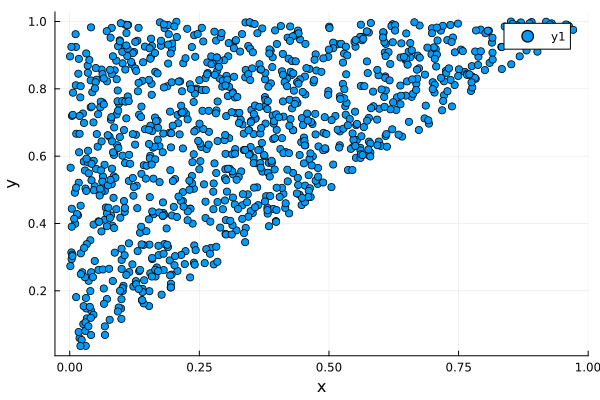

In [3]:
using Plots
y = sqrt.(rand(1000))
x = rand(1000) .* y
scatter(x, y)
xlabel!("x")
ylabel!("y")

# Maxwellian

The probability distribution is
$$
f_V(\vec v)=\frac{1}{(v_{th}\sqrt{\pi})^V}\exp(-\frac{v^2}{v_{th}^2})
$$
where the parameter $V\in(1, 2, 3)$ indicates the dimensionality in velocity space. 

The industry standard for this is the Box-Muller transform, which requires 2 random number draws to give 2 random variables with a standard normal distribution (i.e. two velocity components). It calls to $\log$ and $\sin$ and/or $\cos$ functions amongst a few other standard floating point operations.
$$
v_1=v_{th}\sqrt{-2\ln r_1}\cos{2\pi r_2}\\
v_1=v_{th}\sqrt{-2\ln r_1}\sin{2\pi r_2}\\
$$


Alternatively one may integrate the PDF into a cumulative distribution function and get $v_i=v_{th}{\mathrm {erf}}^{-1}(2r - 1)$. It is assumed that the inverse error function method is slower than the $log$ and $\sin$ and/or $\cos$ calls in the Box-Muller transform but has the benefit of requiring only one random number draw.

### Sampling from a Maxwellian wall source

We can combine the methods of sampling a triangle and sampling from an inverse error function to use only 2 random numbers to generate the $(x, v)$ values from just two random draws:
$$
v = \frac{2v_{th}}{\sqrt\pi}{\mathrm{erf}}^{-1}(\sqrt{r_1})\\
x = - r_2 v \Delta t
$$
The code below samples from a left hand boundary.

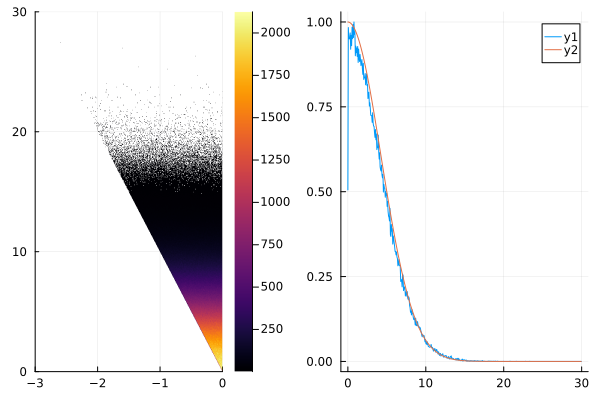

In [2]:
using StatsBase, Plots, SpecialFunctions
vth = 6.0; # arbitrary
dt = 0.1; # arbitrary
N = 1_000_000;
v = 2vth / sqrt(pi) .* erfinv.(sqrt.(rand(N)));
x = -dt * v .* rand(N);
h = StatsBase.fit(Histogram, (x, v), (-5:0.01:0, 0:0.01:5) .* vth .* (dt, 1));
p1 = plot(h);
xx = h.edges[2][1:end-1]
p2 = plot(xx, h.weights[end, :] ./ maximum(h.weights[end, :]));
plot!(p2, xx, exp.(-xx.^2 ./ vth^2));
plot(p1, p2)

This means that we can do away with the reject-accept method and instead sample N particles requiring only one random number per spatial + velocity dimension.

The other two velocity components may be sampled cheaply from the Box-Muller transform.

This above is a histogram of the particles "in the wall".

The method for calculating the weights of particles arising from direct sampling from the wall simplex is more complicated than the accept-reject (RA) method. For the RA method, the particles are sampled at random positions inside the wall up to a distance $-v_{x,max} \Delta t$ from the edge, so that particles may advect into the domain in one timestep, and we sample from all regions in phase-space where particles do this. The weights are then simply the number density multiplied by the spatial extent, and divided by the number of particles (and bear in mind one may only sample from a fraction of the $(x, v_x)$ phase space and this must be taken into account to ensure normalisation).

However, the weights for direct sampling cannot be done this way and require some work with pen-and-paper.

$$
N_{phys,part} = n_0 \int_{0}^{\Delta x}dx\int_{x/\Delta t}^{\infty}dv_x \int_{-\infty}^{\infty}dv_y \int_{-\infty}^{\infty}dv_z f(\vec v)\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\int_{x/\Delta t}^{\infty}dv_x \int_{-\infty}^{\infty}dv_y \int_{-\infty}^{\infty}dv_z \frac{1}{(v_{th}\sqrt{\pi})^V}\exp(-\frac{v^2}{v_{th}^2})\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\int_{x/\Delta t}^{\infty}dv_x \frac{1}{v_{th}\sqrt{\pi}}\exp(-\frac{v_x^2}{v_{th}^2})\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx \left[\frac{1}{2}\mathrm{erf}(\frac{v_x}{v_{th}})\right]_{x/\Delta t}^{\infty}=\frac{n_0}{2} \int_{0}^{\Delta x}dx \left[1-\mathrm{erf}(\frac{x}{v_{th}\Delta t})\right]\\
N_{phys,part}=\frac{n_0}{2} \left[x(1-\mathrm{erf}(\frac{x}{v_{th}\Delta t}))-\frac{v_{th}\Delta t}{\sqrt{\pi}}\exp(-\frac{x^2}{v_{th}^2\Delta t^2})\right]_{0}^{\Delta x}\\
N_{phys,part}=\frac{n_0}{2} \left[\Delta x\left(1-\mathrm{erf}(\frac{\Delta x}{v_{th}\Delta t})\right)-\frac{v_{th}\Delta t}{\sqrt{\pi}}\left(\exp(-\frac{\Delta x^2}{v_{th}^2\Delta t^2})-1\right)\right]\\
$$

When $\Delta x \gg v_{th} \Delta t$ such that $\mathrm{erf}(\frac{\Delta x}{v_{th}\Delta t}) \approx 1$ and if otherwise it would get the wrong answer because particles would not be sampled from an large enough area of phase space. In this limit of large $\Delta x$,
$$
N_{phys,part}=n_0 \frac{v_{th}\Delta t}{2\sqrt{\pi}}.\\
$$
Hence the particle weight $w$ will be $N_{phys,part}/N_{comp,part}$.

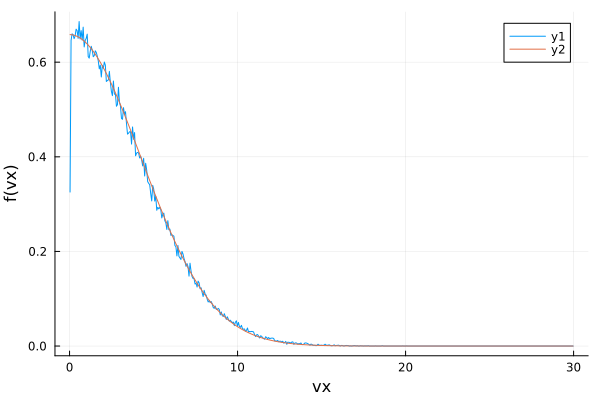

In [8]:
using StatsBase, Plots, SpecialFunctions
vth = 6.0; # arbitrary
dt = 0.1; # arbitrary
n0 = 7.0; # parameter number density
N = 1_000_000;
v = 2vth / sqrt(pi) .* erfinv.(sqrt.(rand(N)));
x = -dt * v .* rand(N);
w = n0 * vth * dt / 2 / sqrt(pi) / N; # weight for all particles
h = StatsBase.fit(Histogram, (x, v), (-5:0.01:0, 0:0.01:5) .* vth .* (dt, 1));
dxdv = (h.edges[1][2] - h.edges[1][1]) * (h.edges[2][2] - h.edges[2][1]);
fxv = h.weights * w / dxdv; # account for particle weight and hist bin size
vv = collect(h.edges[2][1:end-1]); vv .+= (vv[2] - vv[1])/2;
plot(vv, fxv[end, :]) # compare with any first index, not just end
plot!(vv, n0 .* exp.(-vv.^2 ./ vth^2) ./ (vth * sqrt(pi)))
xlabel!("vx")
ylabel!("f(vx)")

## Sampling from a Knudsen cosine distribution

Following the note from John Omotani (private communication 2022) where he decouples the distribution into 3 separable functions and calculates the cumulative distribution function of each from which to sample:
$$
f_{Knudsen,\vec{n}\cdot\vec v >0}(v)=\frac{2}{(v_{th}\sqrt{\pi})^{3}}\frac{\vec n \cdot \vec v}{|v|}\exp(-\frac{v^2}{v_{th}^2})
$$
where
$$
\int_{0}^{\infty}dv_x \int_{-\infty}^{\infty}dv_y \int_{-\infty}^{\infty}dv_\ f_{Knudsen,\vec{n}\cdot\vec v >0}(v)=1
$$


Introducing $\vec n = [1, 0, 0]'$, $\cos\alpha=\frac{\vec n \cdot \vec v}{|v|}$ and $\tan\phi=\frac{v_z}{v_y}$, we arrive at probability distribution functions 

Spherical polar coordinates where $v>0$:
$$
v_x = v \cos \alpha \\
v_y = v \sin \alpha \cos \phi \\
v_z = v \sin \alpha \sin \phi
$$
so
$$
\int_{0}^{\infty}dv_x \int_{-\infty}^{\infty}dv_y \int_{-\infty}^{\infty}dv_z\ f_{Knudsen,\vec{n}\cdot\vec v >0}(\vec v)=1\\
\int_{0}^{\pi/2}d\alpha \int_{-\pi/2}^{\pi/2}d\phi \int_{0}^{\infty}dv_\ f_{Knudsen,\vec{n}\cdot\vec v >0}(v,\alpha,\phi)v^2\sin\alpha=1
$$
hence
$$
\frac{2}{(v_{th}\sqrt{\pi})^{3}} \int_{0}^{\pi/2}d\alpha \int_{-\pi/2}^{\pi/2}d\phi \int_{0}^{\infty}dv \cos\alpha \exp(-\frac{v^2}{v_{th}^2}) v^2 \sin\alpha  = 1
$$
and we know
$$
\int_0^\infty v^2\exp(-\frac{v^2}{v_{th}^2})dv=\frac{v_{th}^2}{4}\left[\sqrt{\pi}v_{th}\mathrm{erf}(\frac{v}{v_{th}})-2v\exp(-\frac{v^2}{v_{th}^2}) \right]_0^\infty=v_{th}^3\frac{\sqrt{\pi}}{4}\\
\int_{0}^{\pi/2}d\alpha \cos\alpha \sin\alpha = \frac{1}{2}\\
\int_{-\pi/2}^{\pi/2}d\phi=2\pi
$$
which shows it's been normalised correctly. Starting with the easiest first
$$
\phi=2\pi r_\phi
$$
Next easiest
$$
F(\alpha)=2\cos\alpha\\
C(\alpha)=2\int_0^\alpha F(\alpha')\sin(\alpha')d\alpha' = 2\int_0^\alpha \cos(\alpha')\sin(\alpha')d\alpha'=2[-\frac{1}{2}\cos^2\alpha']_0^\alpha=(1-\cos^2{\alpha})\\
\alpha=\arccos(\sqrt{1-r_\alpha'})\equiv\arccos(\sqrt{r_\alpha})
$$
last $v$
$$
\int_0^\infty v^2\exp(-\frac{v^2}{v_{th}^2})dv=\frac{v_{th}^2}{4}\left[\sqrt{\pi}v_{th}\mathrm{erf}(\frac{v}{v_{th}})-2v\exp(-\frac{v^2}{v_{th}^2}) \right]_0^\infty=v_{th}^3\frac{\sqrt{\pi}}{4}\\
F(v)=\frac{4}{v_{th}^3\sqrt{\pi}}\exp(-\frac{v^2}{v_{th}^2})\\
C(v)=\int_0^v dv' v'^2 \frac{4}{v_{th}^3\sqrt{\pi}}\exp(-\frac{v'^2}{v_{th}^2})=\left[\mathrm{erf}(\frac{v'}{v_{th}})-\frac{2v'}{v_{th}\sqrt{\pi}}\exp(-\frac{v'^2}{v_{th}^2}) \right]_0^v\\
C(v)=\mathrm{erf}(\frac{v}{v_{th}})-\frac{2v}{v_{th}\sqrt{\pi}}\exp(-\frac{v^2}{v_{th}^2})\\
$$
which is not trivially invertible. A numerical root finding method would be required here, which could be acceptable if this method can be used in conjunction with the triangle method.

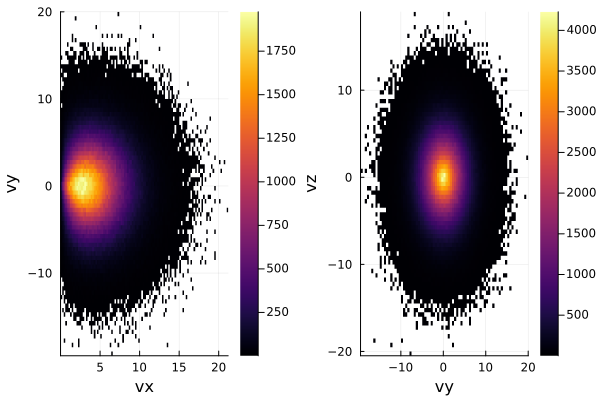

In [4]:
using StatsBase, Plots, SpecialFunctions, Roots
N = 1_000_000
α = acos.(sqrt.(rand(N)));
# the root finder needs a starting guess, which could be:
#  - vth: a constant
#  - r * 3vth: linearly increase from 0 to 3vth
#  - (erfinv(r * 2 - 1) + 2) * vth/sqrt(pi): a more complicated starting guess
invfv(r) = Roots.find_zero(v->erf(v/vth) - 2v/vth/sqrt(pi)*exp(-v^2/vth^2) - r, r * 3vth)
v = invfv.(rand(N));
vx = v .* cos.(α);
ϕ = 2*pi * rand(N);
vy = v .* sin.(α) .* cos.(ϕ);
vz = v .* sin.(α) .* sin.(ϕ);
p1 = plot(StatsBase.fit(Histogram, (vx, vy), nbins=100))
xlabel!(p1, "vx")
ylabel!(p1, "vy")
p2 = plot(StatsBase.fit(Histogram, (vy, vz), nbins=100))
xlabel!(p2, "vy")
ylabel!(p2, "vz")
plot(p1, p2, layout=@layout [a b])

#### Now sample from inside an (x, vx) triangle

Direct sampling but plot only those in a wedge

┌ Info: Precompiling ThreadsX [ac1d9e8a-700a-412c-b207-f0111f4b6c0d]
└ @ Base loading.jl:1664


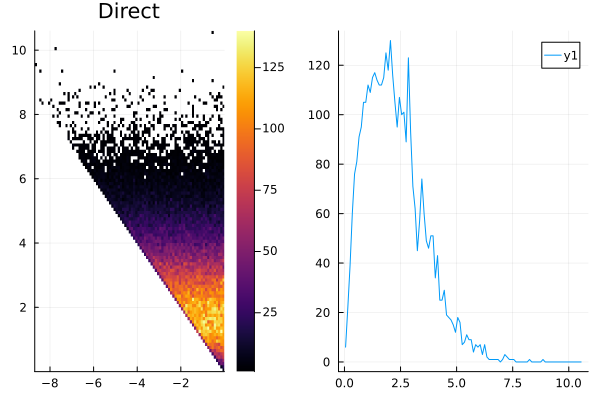

In [5]:
using StatsBase, Plots, SpecialFunctions, Roots, ThreadsX
N = 1_000_000;
vth = 3.0; # arbitrary
dt = 1.0; # arbitrary
n0 = 1.0; # arbitrary number density
invfv(r, V=vth) = Roots.find_zero(v->(u=v/V; erf(u) - 2u/sqrt(pi)*exp(-u^2) - r), r * 3V)
rv = rand(N);
v = ThreadsX.map(invfv, rv);
rα = rand(N);
α = acos.(sqrt.(rα));
vx = v .* cos.(α);
x = - 3rand(N) * 3vth * dt;
ind = vx .> -x / dt; # show only a wedge
h = StatsBase.fit(Histogram, (x[ind], vx[ind]), nbins=(100, 100))
p1 = plot(h, title="Direct");
vv = collect(h.edges[2][1:end-1]); vv .+= (vv[2] - vv[1])/2;
p2 = plot(vv, h.weights[end, :]);
plot(p1, p2)

Indirect sampling with accept-reject method:

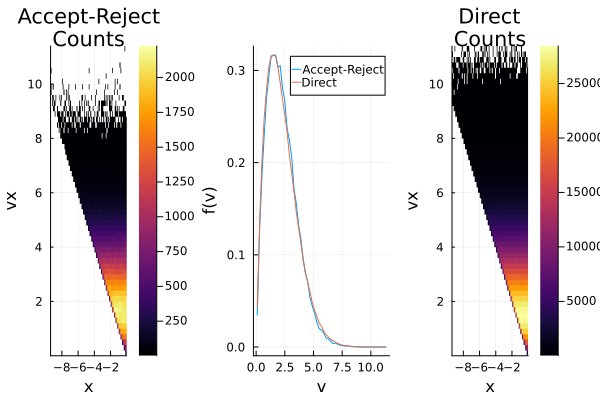

In [11]:
using StatsBase, Plots, SpecialFunctions, Roots, ThreadsX
N = 1_000_000
jacobian(v, α) = v^2 * sin(α)
fvα(v, α, vth=vth) = cos(α) * exp(-v^2 / vth^2)
integrand(v, α, vth=vth) = jacobian(v, α) * fvα(v, α, vth)
function indirectacceptreject(N=10_000_000, vth=3, dt=1, n0=1)
  αs = zeros(N);
  vs = zeros(N);
  vth = 3.0; # arbitrary
  dt = 1.0; # arbitrary
  n0 = 1.0; # arbitrary number density
  i = Ref(0)
  while i[] < N;
    v = rand() * 5vth
    α = rand() * pi/2
    if rand() < integrand(v, α) / 10 # ensure peak is resolved, 10 is a large guess
      i[] += 1
      vs[i[]] = v
      αs[i[]] = α
    end
  end
  return (vs, αs)
end

# brute force accept-reject method but with proper normalisation
(vs, αs) = indirectacceptreject(N, vth, dt, n0)
vx1 = vs .* cos.(αs);
dx1 = 10 * vth * dt;
x1 = - rand(N) * dx1;
ind = vx1 .> -x1 / dt; # select only the wedge in phase space for plotting
h1 = StatsBase.fit(Histogram, (x1[ind], vx1[ind]), nbins=(100, 100))
dxdv = (h1.edges[1][2] - h1.edges[1][1]) * (h1.edges[2][2] - h1.edges[2][1]);
p1 = plot(h1, title="Accept-Reject\nCounts");
xlabel!("x")
ylabel!("vx")
vv = collect(h1.edges[2][1:end-1]); vv .+= (vv[2] - vv[1])/2;
w1 = n0 * dx1 / N; # weight for each particle
fxv1 = h1.weights * w1 / dxdv; # account for particle weight and hist bin size
p2 = plot(vv, fxv1[end, :], label="Accept-Reject");
dxdv = (h1.edges[1][2] - h1.edges[1][1]) * (h1.edges[2][2] - h1.edges[2][1]);

# direct method
invfv(r, V=vth) = Roots.find_zero(v->(u=v/V; erf(u) - 2u/sqrt(pi)*exp(-u^2) - r), r * 2V)
rv = rand(N);
v = ThreadsX.map(x->invfv(x, vth*2/sqrt(pi)), rv);
rα = sqrt.(rand(N));
α = acos.(sqrt.(rα));
vx = v .* cos.(α);
x = -vx .* dt .* rand(N);

h = StatsBase.fit(Histogram, (x, vx), h1.edges)
p3 = plot(h, title="Direct\nCounts");
xlabel!("x")
ylabel!("vx")
dx = maximum(abs, x);
function fsolutionnormalised(dx, dt, vth=vth)
   xi = dx / vth / dt
   return ((erf(xi)-1) * xi * (2 * xi^2 - 3) + 2 * exp(-xi^2)/ sqrt(pi)*(xi^2 - 2) + 4/sqrt(pi))/3
end
fnphyspart(dx, dt, vth=vth) = n0 * vth * dt * fsolutionnormalised(dx, dt, vth)
w = fnphyspart(dx, dt, vth) / N
fxv = h.weights * w / dxdv; # account for particle weight and hist bin size

plot!(p2, vv, fxv[end, :], label="Direct");
xlabel!(p2, "v")
ylabel!(p2, "f(v)")
plot(p1, p2, p3, layout = @layout [a b c])

How to calculate the weights for particles sampled using the direct method (which are above and correct as effectively calculated in `fnphyspart`)?
$$
F(v)=\frac{4}{v_{th}^3\sqrt{\pi}}\exp(-\frac{v^2}{v_{th}^2})\\
C(v)=\mathrm{erf}(\frac{v}{v_{th}})-\frac{2v}{v_{th}\sqrt{\pi}}\exp(-\frac{v^2}{v_{th}^2})\quad, v\in [0, \infty)\\
$$

$$
F(\alpha)=2\cos\alpha\\
C(\alpha)=(1-\cos^2{\alpha})\quad, \alpha\in [0, \pi/2]\\
$$

$$
F(\phi)=\frac{1}{2\pi}\\
C(\phi)=\frac{\phi}{2\pi},\quad \phi\in (0, 2\pi]
$$

Integrating over $\phi$ straight away because we only need the $v-\alpha$  plane. We want $v_x \Delta t >-x$, which corresponds to $v\cos\alpha>-x/\Delta t$
$$
f(v, \alpha, \phi)=\frac{4}{v_{th}^3\sqrt{\pi}^3}\exp(-\frac{v^2}{v_{th}^2})\cos\alpha\\
1=\int_0^\infty dv \int_0^{\pi/2} d\alpha \int_0^{2\pi}d\phi f(v, \alpha, \phi)v^2 \sin \alpha \\
f(v,\alpha)= \int_0^{2\pi}d\phi f(v, \alpha, \phi) = \frac{8}{v_{th}^3\sqrt{\pi}}\exp(-\frac{v^2}{v_{th}^2})\cos\alpha\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv\int_{\alpha_{min}}^{\pi/2}d\alpha f(v, \alpha)v^2\sin\alpha\\
$$
Hence try the integrals this way round: $v_{min}=0$, $v_{max}=\infty$, $\alpha_{min}=0$ (corresponding to $v_x=v$) and  $\alpha_{max}=\arccos{\frac{-x}{v\Delta t}}$. The other way is $v_{min} = -x/(\Delta t\cos\alpha)$ but that would give an error function with a cosine argument, which clearly is less appealing.



This answer must make sense when $\Delta t\rightarrow\infty$ the number of particles goes to $n_0\Delta x$ and also sense when $\Delta t \rightarrow 0$. Testing it more rigorously

In [12]:
using HCubature, Test, SpecialFunctions
# ensure starting from a normalised distribution function
vth = 3.0; # arbitrary

fαv(x, vth=vth) = 8 / (vth^3 * sqrt(pi)) * cos(x[1]) * exp(-x[2]^2/vth^2)
jacobian(x) = sin(x[1]) * x[2]^2
heaviside(x) = x > 0;
@test 1 ≈ HCubature.hcubature(x-> fαv(x) * jacobian(x), (0, 0), (pi/2, 6*vth), rtol=1e-12)[1]
dx, dt = 5.0, 1000.0; # limit of large time, therefore integral tends to dx
longtime = HCubature.hcubature(x-> fαv(x) * jacobian(x) * (heaviside(x[3] + dt * x[2] * cos(x[1]))),
  (0, 0, -dx), (pi/2, 6*vth, 0), rtol=1e-4)[1]
@test isapprox(longtime, dx, rtol=1e-3)

vmax = 6 * vth; # maximum possible speed
dt = dx / vmax;

using QuadGK
∫α(x, v, vth=vth, dt=dt, rtol=1e-5) = QuadGK.quadgk(α -> fαv([α, v], vth) * jacobian([α, v]), 
  0, acos(-x/v/dt), rtol=rtol)[1]
∫v(x, vth=vth, dt=dt, rtol=1e-4) = QuadGK.quadgk(v -> ∫α(x, v, vth, dt, rtol/8), abs(x/dt), Inf, rtol=rtol)[1]
∫xvα(dx=dx, dt=dt, vth=vth, rtol=1e-3) = QuadGK.quadgk(x -> ∫v(x, vth, dt, rtol/8), -dx, 0, rtol=rtol)[1]

function fsolutionnormalised(dx, dt, vth=vth)
   xi = dx / vth / dt
   return ((erf(xi)-1) * xi * (2 * xi^2 - 3) + 2 * exp(-xi^2)/ sqrt(pi)*(xi^2 - 2) + 4/sqrt(pi))/3
end
fsolution(dx, dt, vth=vth) = vth * dt * fsolutionnormalised(dx, dt, vth)

@test isapprox(∫xvα(dx, dt, vth), fsolution(dx, dt, vth), rtol=1e-3)


Test Passed

Knowing also the constraint the argument to $\arccos$ must be in the range $[-1, 1]$ we have a lower limit on velocity $\frac{|x|}{t}\leq v\lt \infty$. Hence $v_{min}=\frac{-x}{t}$ in this case where we consider the left hand boundary. But in general $v_{min}=x/t$ and integrating from $0 .. \Delta x$ will suffice and indeed the sign in the argument to $\arccos$ ends up being squared away.

$$
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv\int_{0}^{\arccos{\frac{-x}{v\Delta t}}}d\alpha f(v, \alpha)v^2\sin\alpha\\
N_{phys,part}=n_0 \frac{8}{v_{th}^3\sqrt{\pi}}\int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv\int_{0}^{\arccos{\frac{-x}{v\Delta t}}}d\alpha \exp(-\frac{v^2}{v_{th}^2})v^2\cos\alpha \sin\alpha\\
N_{phys,part}=n_0 \frac{8}{v_{th}^3\sqrt{\pi}}\int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv \exp(-\frac{v^2}{v_{th}^2})v^2\frac{1}{2}\left[-\cos^2(\alpha)\right]_{0}^{\arccos{\frac{-x}{v\Delta t}}}\\
N_{phys,part}=n_0 \frac{8}{v_{th}^3\sqrt{\pi}}\int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv \exp(-\frac{v^2}{v_{th}^2})v^2\frac{1}{2}\left[1-\cos^2(\arccos{\frac{-x}{v\Delta t}})\right]\\
N_{phys,part}=n_0 \frac{4}{v_{th}^3\sqrt{\pi}}\int_{0}^{\Delta x}dx\int_{v_{min}}^{\infty}dv \exp(-\frac{v^2}{v_{th}^2})\left[v^2-\frac{x^2}{\Delta t^2}\right]\\
N_{phys,part}=n_0 \frac{4}{v_{th}^3\sqrt{\pi}}\int_{0}^{\Delta x}dx\left[\frac{v_{th}\sqrt{\pi}}{2}[\frac{v_{th}^2}{2}-\frac{x^2}{\Delta t^2}]\mathrm{erf}(\frac{v}{v_{th}})-\frac{1}{2}v_{th}^2v\exp(-\frac{v^2}{v_{th}^2})\right]_{v_{min}}^\infty\\
N_{phys,part}=n_0 2\int_{0}^{\Delta x}dx\left[[\frac{1}{2}-\frac{x^2}{v_{th}^2\Delta t^2}]\mathrm{erf}(\frac{v}{v_{th}})-\frac{1}{\sqrt{\pi}}\frac{v}{v_{th}}\exp(-\frac{v^2}{v_{th}^2})\right]_{v_{min}}^\infty\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\left[[1-\frac{2 x^2}{v_{th}^2\Delta t^2}](1-\mathrm{erf}(\frac{v_{min}}{v_{th}}))+\frac{2}{\sqrt{\pi}}\frac{v_{min}}{v_{th}}\exp(-\frac{v_{min}^2}{v_{th}^2})\right]\\
N_{phys,part}=n_0 \int_{0}^{\Delta x}dx\left[[1-\frac{2 x^2}{v_{th}^2\Delta t^2}](1-\mathrm{erf}(\frac{x}{\Delta t v_{th}}))+\frac{2}{\sqrt{\pi}}\frac{x}{\Delta t v_{th}}\exp(-\frac{x^2}{\Delta t^2 v_{th}^2})\right]\\
$$

Introduce $\xi=\frac{x}{v_{th}\Delta t}$ and $\xi_{max}=\frac{\Delta x}{v_{th}\Delta t}$

$$
N_{phys,part}=n_0 \int_{0}^{\Delta x/v_{th}\Delta t}v_{th}\Delta t d\xi\left[[1-{2 \xi^2}](1-\mathrm{erf}(\xi)+\frac{2}{\sqrt{\pi}}\xi\exp(-\xi^2)\right]\\
N_{phys,part}=n_0 v_{th}\Delta t \frac{1}{3}\left[\xi(\mathrm{erf}(\xi)-1)(2\xi^2 -3)+\frac{2\exp(-\xi^2)}{\sqrt{\pi}}(\xi^2 - 2) \right]_{0}^{\xi_{max}}\\
N_{phys,part}=n_0 v_{th}\Delta t \frac{1}{3}\left[\xi_{max}(\mathrm{erf}(\xi_{max})-1)(2\xi_{max}^2 -3)+\frac{2\exp(-\xi_{max}^2)}{\sqrt{\pi}}(\xi_{max}^2 - 2) + \frac{4}{\sqrt{\pi}}\right]\\
$$

It is easy to see that the large $\Delta x$ behavious is $n_0 v_{th}\Delta t \frac{4}{3 \pi^{1/2}}$.

In [26]:
using QuadGK, Test, SpecialFunctions
vth = 3.0
dx = 5.0;
dt = dx / 10vth;
fxi(xi) = ((1-2*xi^2) *(1-erf(xi)) + 2/sqrt(pi)*xi*exp(-xi^2))
quadfx(dx, dt, vth=vth) = vth * dt * QuadGK.quadgk(fxi, 0, dx / vth / dt)[1]

function fsolutionnormalised(dx, dt, vth=vth)
   xi = dx / vth / dt
   return ((erf(xi) - 1) * xi * (2 * xi^2 - 3) + 2 * exp(-xi^2)/ sqrt(pi)*(xi^2 - 2) + 4/sqrt(pi))/3
end
fsolution(dx, dt, vth=vth) = vth * dt * fsolutionnormalised(dx, dt, vth)
@test fsolution(dx, dt, vth) ≈ quadfx(dx, dt, vth)
@test fsolution(dx, dt/10, vth) ≈ quadfx(dx, dt/10, vth)
@test fsolution(dx, 10dt, vth) ≈ quadfx(dx, 10dt, vth)
@test fsolution(10dx, dt, vth) ≈ quadfx(10dx, dt, vth)
@test fsolution(dx/10, dt, vth) ≈ quadfx(dx/10, dt, vth)

@test fsolution(dx, dt, vth) ≈ ∫xvα(dx, dt, vth)[1] # defined above

Test Passed

## Brute force method

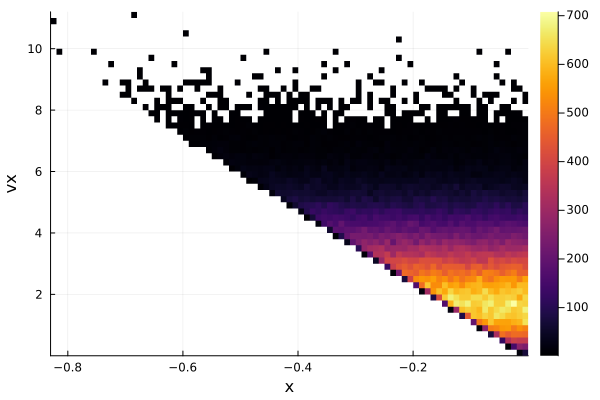

In [27]:
using StatsBase, Plots, SpecialFunctions, Roots
N = 1_000_000
α = acos.(sqrt.(rand(N)));
invfv(r) = Roots.find_zero(v->erf(v/vth) - 2v/vth/sqrt(pi)*exp(-v^2/vth^2) - r, r * 2vth)
v = invfv.(rand(N));
vx = v .* cos.(α);
ϕ = 2*pi * rand(N);
vy = v .* sin.(α) .* cos.(ϕ);
vz = v .* sin.(α) .* sin.(ϕ);
dt = 1 / 4vth # artbitrary
x = - rand(N);
ind = vx .> -x / dt 
plot(StatsBase.fit(Histogram, (x[ind], vx[ind]), nbins=100))
xlabel!("x")
ylabel!("vx")